In [1]:
import pickle
from scipy import sparse
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import spektral
import os
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras_tuner as kt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import openpyxl

In [2]:
counter = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\counterflow.xlsx")
dat = pd.DataFrame(counter)
hot_rate = dat["Ms (kg/s)"]
cold_rate = dat["Mi1 (kg/s)"]
wc = cold_rate
wh = hot_rate
Th_in = dat["Th_in"]
Th_out = dat["Th_out"]
Tc_in = dat["Tc_in"]
Tc_out = dat["Tc_out"]


In [138]:
dT_counter = ((Th_in - Tc_out) - (Th_out - Tc_in))/np.log(((Th_in - Tc_out)/(Th_out - Tc_in)))
Cp = 4.182 #kJ/kgC
Qc = wc*Cp*(Tc_out- Tc_in)      #Qc = wc*Cp_c*(Tc_out - Tc_in)
Qh = wh*Cp*(Th_out- Th_in)   #Qh = wh*Cp_h*(Th_out- Th_in)
Q = (abs(Qc) + abs(Qh))/2
A = 31*np.pi*7.875*0.21/(39.37*39.37)
U = Q/(A*dT_counter)
Gi = wc/(np.pi*31*np.power((0.21/39.37),2)/4)
Gs = wh/((np.pi*np.power((2.025/39.37),2)/4)-(np.pi*31*np.power((0.25/39.37),2)/4))
#dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
flip_U = 1/U
print(dT_counter)

0     25.986878
1     31.486197
2     34.586005
3     35.070922
4     34.755799
5     33.817230
6     28.841551
7     35.546495
8     39.722830
9     38.878646
10    39.143120
11    39.056169
12    28.161102
13    34.556978
14    37.754636
15    39.032857
16    39.171157
17    39.172481
18    28.673353
19    31.241948
20    32.690074
21    34.449774
22    36.373127
23    37.442302
24    29.470134
25    33.749697
26    36.085526
27    36.608481
28    36.748178
29    36.538557
30    26.787663
31    28.364428
32    31.128521
33    32.939128
34    34.100713
35    35.307152
dtype: float64


In [103]:
def func(G,a,b,c,d,e):
    Gi,Gs = G
    return (a/np.power(Gi,b)) + c + (d/np.power(Gs,e))

In [113]:
guess = [1, 0.3, 2, 1,0.7]
a,b,c,d,e = guess
LHS = func((Gi,Gs),a,b,c,d,e)
param = curve_fit(func,(Gi,Gs),flip_U,guess,bounds=(0, [300, 3, 10,30,10]))
LHS_fit = func((Gi,Gs),*param[0])
U_fit = 1/LHS_fit

print(param)

(array([40.09097501,  1.07622526,  0.22815733,  0.44152376,  5.93986915]), array([[9.42578585e+01, 7.44109963e-01, 1.62889406e-01, 0.00000000e+00,
        0.00000000e+00],
       [7.44109963e-01, 5.97424812e-03, 1.38398976e-03, 0.00000000e+00,
        0.00000000e+00],
       [1.62889406e-01, 1.38398976e-03, 5.03342276e-04, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]]))


In [109]:
# = param[0][0]
h_exp = 1/param[0][0]*(np.power(Gi,param[0][1]))
#
k = 0.000598 # kW/mK
Di = 0.21/39.37
miu_i = np.power(1/10,3)
h_i = 0.023*k/(Di)*np.power((Di*Gi/miu_i),0.8)*np.power((Cp*miu_i/k),1/3)
print(h_i,h_exp,miu_i,Gi,Gs)

0     0.457603
1     1.090160
2     1.964152
3     2.758385
4     4.295558
5     4.503289
6     0.285938
7     0.846497
8     1.403876
9     2.089958
10    2.773923
11    3.475534
12    0.358829
13    0.882113
14    1.315630
15    2.169359
16    2.684988
17    3.570684
18    0.333200
19    0.951443
20    1.317504
21    2.114787
22    3.035061
23    3.570684
24    0.333200
25    0.934079
26    1.681118
27    2.524791
28    3.131353
29    3.748177
30    0.197805
31    0.618235
32    1.189191
33    1.848461
34    2.731149
35    3.748177
Name: Mi1 (kg/s), dtype: float64 0      1.690470
1      4.918626
2     10.148939
3     15.412380
4     26.579213
5     28.169324
6      0.947876
7      3.603078
8      6.714001
9     10.954522
10    15.519263
11    20.481134
12     1.253378
13     3.790488
14     6.198578
15    11.468779
16    14.909376
17    21.173161
18     1.144161
19     4.160275
20     6.209446
21    11.114857
22    17.335804
23    21.173161
24     1.144161
25     4.067057
26     8.38

In [110]:
dat_plot = [Gi,flip_U,h_exp]
dat_plot_in = pd.DataFrame({'col1': Gi,
                            'col2':flip_U,
                           'col3': h_exp,
                           'col4': h_i}
                          )
dat_plot_sort = dat_plot_in.sort_values(by = "col1",ascending= True)
print(dat_plot_in.sort_values(by = "col1",ascending= True))

          col1      col2       col3      col4
30   18.926547  1.996383   0.602359  0.197805
6    29.999571  1.071910   0.947876  0.285938
24   36.320941  1.180200   1.144161  0.333200
18   36.320941  1.160138   1.144161  0.333200
12   39.846055  0.801217   1.253378  0.358829
0    53.999228  0.740587   1.690470  0.457603
31   78.653494  0.621386   2.447755  0.618235
7   116.495173  0.493777   3.603078  0.846497
13  122.653939  0.393067   3.790488  0.882113
25  131.751498  0.504022   4.067057  0.934079
19  134.820129  0.458719   4.160275  0.951443
1   159.822913  0.487023   4.918626  1.090160
32  178.172370  0.402099   5.473970  1.189191
14  202.159008  0.386590   6.198578  1.315630
20  202.519122  0.376465   6.209446  1.317504
8   219.248664  0.449184   6.714001  1.403876
26  274.646274  0.356261   8.380669  1.681118
33  309.235219  0.330009   9.418535  1.848461
2   333.614412  0.359710  10.148939  1.964152
9   360.535384  0.296548  10.954522  2.089958
21  365.897344  0.298442  11.11485

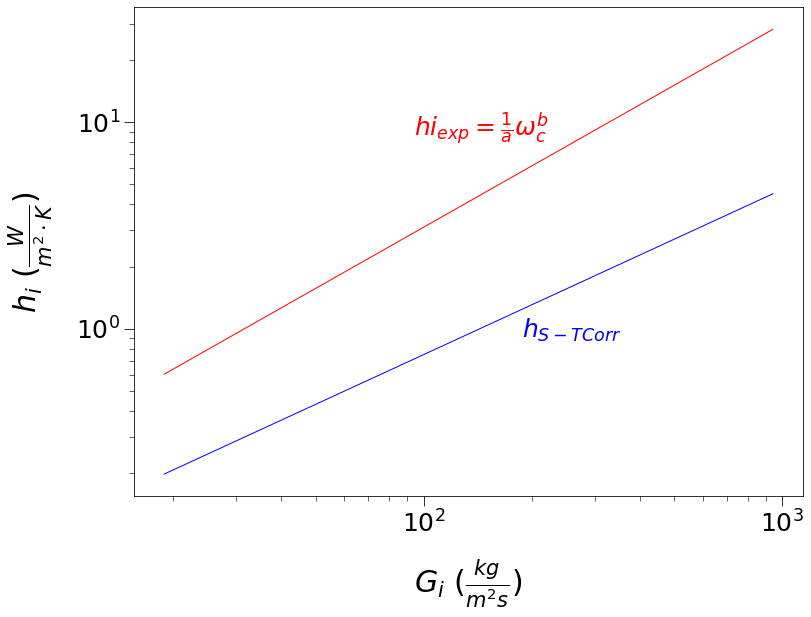

In [137]:
figure(figsize = (12,9))
l_width = 1
Gi_plot,flip_U_plot,h_exp_plot,h_i_plot = dat_plot_sort["col1"],dat_plot_sort["col2"],dat_plot_sort["col3"],dat_plot_sort["col4"]
plt.loglog(Gi_plot,h_exp_plot,'r-',linewidth = l_width, label = "$h_{Exp}$") 
plt.loglog(Gi_plot,h_i_plot,'b-',linewidth = l_width, label = "hi_i_ST")
plt.ylabel(r"$h_{i}$ $(\frac{W} {m^{2} \cdot{K}})$", fontsize = 30,labelpad=20)
plt.xlabel(r"$G_i$ $(\frac{kg} {m^{2}s})$",fontsize = 30,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.annotate((r"$hi_{exp} =  \frac{1} {a} \omega_c^b$"),
             xy = (   Gi_plot.to_numpy()[-1],h_exp_plot.to_numpy()[-1]),
             xytext= (   0.1*(Gi_plot.to_numpy()[-1]),(0.3*h_exp_plot.to_numpy()[-1])),
             color = 'r',fontsize = 25)

plt.annotate("$h_{S-T Corr}$",
             xy = (   Gi_plot.to_numpy()[-1],h_i_plot.to_numpy()[-1]),
             xytext= (   0.2*Gi_plot.to_numpy()[-1],0.2*(h_i_plot.to_numpy()[-1])),
             color = 'b',fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=25, length = 10)
plt.tick_params(axis='both', which='minor', length = 5)

In [81]:
Gi_plot.to_numpy()[-1]
h_exp_plot.to_numpy()[-1]

38909.56540263888